# Rhythmic Predictability of Weak-Transient Orchestral Music with Anton Webern, Symphonie Op. 21

## Abstract

We compare the human ability to perceive a musical pulse in
weak-transient orchestral music, i.e., being able to physically feel 
the pulse or beat of music which would not be considered beat music ;)

Traditioal information retrieval approaches like librosa beat detection do
not provide usable results because they often rely on hard transients in the 
audio signal.

We provide manual beat annotation by music professionals for three different interpretations and recordings
of the second movement of Anton Weberns 21st Symphonie.

We show how well the listeners "agree" on a pulse and relate the results to properties in the audio signal.

We train a network that will eventually do cool stuff.

## Introduction

Anton Weberns 21st Symphonie is not easy to rhythmically perceive correctly for the "unexperienced ear". We classify individual parts different recordings into easy-/ and hard-to-perceive parts.

## Open Music Annotations

Open Music Annotations resembles an open database for any type of musical annotation data, i.e., data attached to an instant in an audio recording (or any type of streaming media).


### Specify Data Location and Login

Access Tokens are provided through the web interface.

In [83]:
# import omapy library
from omapy.api import oma

# API endpoint
url = "http://localhost:8080/"
# url = "http://omatest.eu-central-1.elasticbeanstalk.com/"
# Login with username, password and flag that indicates if certificates are validated or not. False: useful for non-production
login = oma.login(url, "oma", "=PSe?sZ-ymp6mE>2", False)
# response code 200
print(login)

<Response [200]>


### Library Calls for Data Access

Omapy provides methods encapsulating http requests to oma API


In [26]:
# each method requires a set of parameters
# Example: composer_find requires
# findBy: attribute X to look for
# X: the value of X
# params {"findBy": "age", "age": "59"}
# params {"findBy": "birthPlace", "birthPlace": "Vienna"}

# set query parameters
params = {"findBy": "name", "name": "Anton Webern"}

# fetch data and pick the first result
composer = oma.composer_find(params)[0]

# composer data structure
print(composer)

{'name': 'Anton Webern', 'composerId': 52790, 'compositions': [{'compositionId': 52791, 'compositionTitle': 'Symphonie Op. 21'}]}


In [29]:
# use the composer id to query all compositions of composer
params = {"findBy": "composer", "composer": composer["composerId"]}

# fetch data
compositions = oma.composition_find(params)
print(compositions)



[{'compositionId': 52791, 'composerId': 52790, 'compositionTitle': 'Symphonie Op. 21'}]


In [30]:
# note that this is a list of compositions
for composition in compositions:
    print(composition)


{'compositionId': 52791, 'composerId': 52790, 'compositionTitle': 'Symphonie Op. 21'}


In [34]:
# the composition we are interested in
composition = compositions[0]

compositionId = composition["compositionId"]

print(compositionId)

52791


### Interpretations

We are interested in data of actual recordings, so we search for interpretations of the piece of interest

In [52]:
# interpretation_find can search for recordings of a certain composition

params = {"findBy": "composition", "composition": compositionId}
interpretations = oma.interpretation_find(params)

for interpretation in interpretations:
    print(interpretation)


{'interpretation': 'Pierre Boulez, Berliner Philharmoniker, 1994', 'recordingId': 53395}
{'interpretation': 'Giuseppe Sinopoli, SKD, 1996', 'recordingId': 54201}
{'interpretation': 'Pierre Boulez, LSO, 1969', 'recordingId': 53599}
{'interpretation': 'Herbert von Karajan, Berliner Philharmoniker, 1974', 'recordingId': 52794}


In [53]:
# pandas data frames makes life easier
# https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html
import pandas as pd

df_interpretations = pd.DataFrame(data=interpretations)
df_interpretations.head()


,interpretation,recordingId
0,"Pierre Boulez, Berliner Philharmoniker, 1994",53395
1,"Giuseppe Sinopoli, SKD, 1996",54201
2,"Pierre Boulez, LSO, 1969",53599
3,"Herbert von Karajan, Berliner Philharmoniker, ...",52794


### Looking for Annotations

Annotations are linked to recordings, so we use our recordingIds to query for annotation data


In [93]:
# annotations = oma.annotation_find({"findBy": "recording", "recording": recording["id"]})
# 

annotations = []

for interpretation in interpretations:
    print(interpretation)
    a = oma.annotation_find({"findBy": "recording", "recording": interpretation["recordingId"]})
    annotations.extend(a)

#a = oma.annotation_find({"findBy": "recording", "recording": interpretations[0]["recordingId"]})
#annotations.extend(a)

#print(annotations[0])
df_annotations = pd.DataFrame(data=annotations)
df_annotations.head()
    

{'interpretation': 'Pierre Boulez, Berliner Philharmoniker, 1994', 'recordingId': 53395}
{'interpretation': 'Giuseppe Sinopoli, SKD, 1996', 'recordingId': 54201}
{'interpretation': 'Pierre Boulez, LSO, 1969', 'recordingId': 53599}
{'interpretation': 'Herbert von Karajan, Berliner Philharmoniker, 1974', 'recordingId': 52794}


,annotationId,annotationSession,barNumber,beatNumber,intValue,momentOfPerception,recordingId,subDivision,type
0,102020,102019,1.0,1.0,NaN,1.376576,53395,None,Tap
1,102021,102019,1.0,2.0,NaN,2.132404,53395,None,Tap
2,102022,102019,2.0,1.0,NaN,2.981701,53395,None,Tap
3,102023,102019,2.0,2.0,NaN,3.801769,53395,None,Tap
4,102024,102019,3.0,1.0,NaN,4.551111,53395,None,Tap


In [95]:
# data frame description

df_grouped = df_annotations.groupby(["type", "recordingId", "barNumber", "beatNumber"])["momentOfPerception"]

df_grouped.describe()

count        mean       std  \
type recordingId barNumber beatNumber                                
Tap  52794       1.0       1.0           3.0    0.859509  0.041581   
                           2.0           3.0    1.819426  0.104145   
                 2.0       1.0           3.0    2.843840  0.073746   
                           2.0           3.0    3.825926  0.065248   
                 3.0       1.0           3.0    4.812872  0.088947   
                           2.0           3.0    5.630786  0.037981   
                 4.0       1.0           3.0    6.704293  0.012977   
                           2.0           3.0    7.614195  0.027408   
                 5.0       1.0           3.0    8.519667  0.038561   
                           2.0           3.0    9.452373  0.064587   
                 6.0       1.0           3.0   10.316961  0.008661   
                           2.0           3.0   11.224512  0.014220   
                 7.0       1.0           3.0   12.146977  0.035324   
                           2.0           3.0   13.034308  0.053480   
                 8.0       1.0           3.0   14.037596  0.018421   
                           2.0           3.0   14.870106  0.063367   
                 9.0       1.0           3.0   15.715389  0.027333   
                           2.0           3.0   16.585631  0.077630   
                 10.0      1.0           3.0   17.509237  0.067108   
                           2.0           3.0   18.357052  0.009115   
                 11.0      1.0           3.0   19.223749  0.008308   
                           2.0           3.0   20.042525  0.031361   
                 12.0      1.0           3.0   20.800363  0.034031   
                           2.0           3.0   21.475389  0.032698   
                 13.0      1.0           3.0   22.152502  0.002340   
                           2.0           3.0   22.819962  0.008478   
                 14.0      1.0           3.0   23.449358  0.005648   
                           2.0           3.0   24.006546  0.005682   
                 15.0      1.0           3.0   24.652774  0.030182   
                           2.0           3.0   25.261126  0.038782   
...                                      ...         ...       ...   
     54201       85.0      1.0           1.0  139.517098       NaN   
                           2.0           1.0  140.457506       NaN   
                 86.0      1.0           1.0  141.386304       NaN   
                           2.0           1.0  142.640181       NaN   
                 87.0      1.0           1.0  143.673469       NaN   
                           2.0           1.0  144.358458       NaN   
                 88.0      1.0           1.0  145.333696       NaN   
                           2.0           1.0  146.262494       NaN   
                 89.0      1.0           1.0  147.156463       NaN   
                           2.0           1.0  148.338231       NaN   
                 90.0      1.0           1.0  149.292993       NaN   
                           2.0           1.0  150.175782       NaN   
                 91.0      1.0           1.0  151.103855       NaN   
                           2.0           1.0  152.032653       NaN   
                 92.0      1.0           1.0  152.998889       NaN   
                           2.0           1.0  154.041179       NaN   
                 93.0      1.0           1.0  155.099524       NaN   
                           2.0           1.0  156.045737       NaN   
                 94.0      1.0           1.0  157.036553       NaN   
                           2.0           1.0  157.918912       NaN   
                 95.0      1.0           1.0  158.731610       NaN   
                           2.0           1.0  159.762268       NaN   
                 96.0      1.0           1.0  160.632562       NaN   
                           2.0           1.0  161.579614       NaN   
                 97.0      1.0           1.0  162

In [90]:

# legacy stuff below!

# build set of annotations for all interpretations
input_data_set = []

for interpretation in interpretations:
    # print("interpretation")
    # print(interpretation["id"])
    recordings = interpretation['recordings']
    recording = recordings[0]  # the first one we get. additional care must be taken if there are many
    # print(json.dumps(recording, indent=4, sort_keys=True))
    # print(recording)
    
    params = {"findBy": "recording", "recording": recording["id"]}
    annotations = oma.annotation_find(params)
    # print ("Annotations")
    # print(annotations)
    
    for annotation in annotations:
        # remove unused fields
        del annotation["intValue"]
        
        # resolve references
        annotation["session"] = annotation["session"]["id"]
        
        # add grouping data
        annotation["recording"] = recording["id"]
        annotation["recordingTitle"] = recording["title"]
        annotation["digitalAudio"] = recording["digitalAudio"][0]["id"]
        annotation["interpretation"] = interpretation["interpretationId"]
        annotation["partTitle"] = interpretation["title"]
        annotation["interpretationTitle"] = interpretation["interpretation"]["title"]
        
        
        input_data_set.append(annotation)
        
        
# Finally convert the data structure in a pandas data frame
df_input_data_set = pd.DataFrame(data=input_data_set)
df_input_data_set.head()
# from here on we are going to use df_input_data_set

KeyError: 'recordings'

In [29]:
# get a recording as example
params = {"recording": 53395}

audio_file = oma.recording_get_audio(params)

print(audio_file.name)

opened
omacache/recording/53395.mp3


/home/martin/Workspace/oma/jupyter/JUPYTER/lib/python3.5/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Text(0.5, 1.0, 'Stereo Wave')

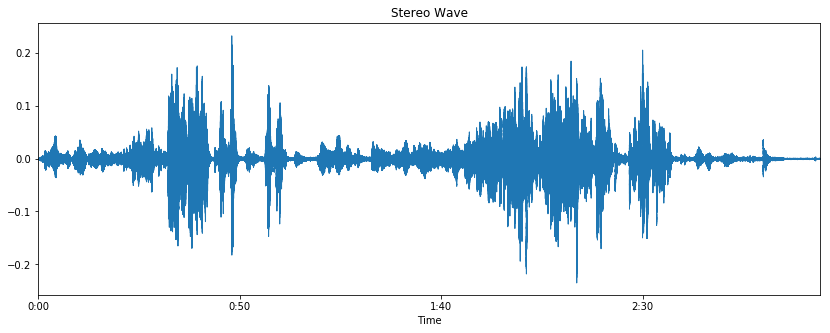

In [30]:
import librosa

y, sr = librosa.load(audio_file.name, sr=44100, mono=False)

import matplotlib.pyplot as plt
import librosa.display


plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)
plt.title('Stereo Wave')


In [22]:
import IPython.display as ipd
ipd.Audio(audio_file.name)

In [32]:
# group by interpretation, beat and bar and recording and get the average moment of perception for each one of them
df_grouped = df_input_data_set.groupby(["interpretation", "interpretationTitle", "barNumber", "beatNumber"])["momentOfPerception"]

df_grouped.describe()

count  \
interpretation interpretationTitle                                barNumber beatNumber          
52792          Herbert von Karajan, Berliner Philharmoniker, 1974 1.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  2.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  3.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  4.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  5.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  6.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  7.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  8.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  9.0       1.0           3.0   
                                                                            2.0           3.0   
                                                                  10.0      1.0           3.0   
                                                                            2.0           3.0   
                                                                  11.0      1.0           3.0   
                                                                            2.0           3.0   
                                                                  12.0      1.0           3.0   
                                                                            2.0           3.0   
                                                                  13.0      1.0           3.0   
                                                                            2.0           3.0   
                                                                  14.0      1.0           3.0   
                                                                            2.0           3.0   
                                                                  15.0      1.0           3.0   
                                                                            2.0           3.0   
...                                                                                       ...   
54199          Giuseppe Sinopoli, SKD, 1996                       85.0      1.0           1.0   
                                                                            2.0           1.0   
                                                                  86.0      1.0           1.0   
                                                                            2.0           1.0   
                                                                  87.0      1.0           1.0   
                                                                            2.0           1.0   
                                                                  88.0      1.0           1.0   
                                                                            2.0           1.0   
                                                                  89.0      1.0           1.0   
              

In [36]:
df_grouped = df_input_data_set.groupby(["interpretation", "interpretationTitle", "barNumber", "beatNumber"])["momentOfPerception"]
df_grouped.head()

0         1.376576
1         2.132404
2         2.981701
3         3.801769
4         4.551111
5         5.340590
6         6.144966
7         6.911837
8         7.662585
9         8.426599
10        9.250907
11       10.042222
12       10.843356
13       11.615125
14       12.422676
15       13.165714
16       13.875918
17       14.590499
18       15.350975
19       16.179955
20       17.042902
21       17.795896
22       18.540590
23       19.185102
24       19.792630
25       20.425805
26       21.050204
27       21.654014
28       22.301859
29       22.926757
           ...    
1558    166.548503
1559    167.723061
1560    169.003401
1561    170.945828
1562    171.862494
1563    173.007007
1564    174.114830
1565    175.229388
1566    176.274376
1567    178.120363
1568    178.921451
1569    180.589773
1570    181.336327
1571    182.318776
1572    183.565351
1573    184.737959
1574    186.163243
1575    188.169637
1576    189.149751
1577    190.136644
1578    191.632154
1579    193.

In [25]:
# we want to know where the stddev is either large of small
standard_deviations = df_input_data_set.groupby(["interpretation", "interpretationTitle", "barNumber", "beatNumber"])["momentOfPerception"].std()

# what is the mean standard deviation?
standard_deviations.describe()

count    396.000000
mean       0.056903
std        0.075012
min        0.002120
25%        0.018604
50%        0.034270
75%        0.062607
max        0.576584
Name: momentOfPerception, dtype: float64

In [14]:
mean_standard_deviation = standard_deviations.mean()
mean_standard_deviation

0.0569031087422747

In [ ]:
# now, compare each beats standatd deviation to that mean and see, if the beat is below or abobe "average perceiveability"


# plot the stddev over time and classify everything above agv(stddev) as hard and everything below as easy.

